<a href="https://colab.research.google.com/github/Sim98B/ShroomVision/blob/main/SV4/ShroomVision4Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shroom Vision 4 Deployment

## Setup

In [9]:
# Importing main libraries
try:
  import torch
  print(f"torch: {torch.__version__}")
  import torchvision
  print(f"torchvision: {torchvision.__version__}")
  import torchinfo
  print(f"torchinfo: {torchinfo.__version__}")
except:
  print("[INFO] Torch and Torchvision not installed, downloading")
  !pip install -q torch torchvision torchinfo
  import torch
  import torchvision
  import torchinfo

# Utilities
import os
import zipfile
from pathlib import Path
import requests
import shutil
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

# Manipulation
import numpy as np
import pandas as pd

# Neural networks
from torch import nn
from torchvision import transforms
import torchvision.models
from torchinfo import summary

# Cloning GitHub repository
!git clone https://github.com/Sim98B/ShroomVision
!mv ShroomVision/Modules/Libraries .
!mv ShroomVision/Data .
!mv ShroomVision/SV4/Models .

# Custom functions
from Libraries import data, extractors, model_ops, utils

shutil.rmtree("ShroomVision")

torch: 2.1.0+cu118
torchvision: 0.16.0+cu118
torchinfo: 1.8.0
Cloning into 'ShroomVision'...
remote: Enumerating objects: 3239, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 3239 (delta 22), reused 6 (delta 1), pack-reused 3188
Receiving objects: 100% (3239/3239), 468.76 MiB | 34.53 MiB/s, done.
Resolving deltas: 100% (677/677), done.
Updating files: 100% (1733/1733), done.
mv: cannot move 'ShroomVision/Modules/Libraries' to './Libraries': Directory not empty
mv: cannot move 'ShroomVision/Data' to './Data': Directory not empty
mv: cannot move 'ShroomVision/SV4/Models' to './Models': Directory not empty


In [2]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Data

In [3]:
# Validation and test data
data_path = Path("Data")
val_dir = data_path / "val_data"
val_paths_list = list(Path(val_dir).glob("*/*.jpg"))

test_dir = data_path / "test_data"
test_paths_list = list(Path(test_dir).glob("*/*.jpg"))

data.inspect_dir(data_path)

# Extracting trained DenseNet161 paramters
densenet161_zip = Path("Models/DenseNet161_20epochs.zip")

with zipfile.ZipFile(densenet161_zip, 'r') as zip_ref:
  zip_ref.extractall(Path("Models"))

densenet161_weights_path = Path("Models/State_dicts/20_epochs_DenseNet161.pth")

There are 3 directory/ies and 0 file/s in Data
There are 4 directory/ies and 0 file/s in Data/test_data
There are 0 directory/ies and 173 file/s in Data/test_data/boletus_edulis
There are 0 directory/ies and 16 file/s in Data/test_data/amanita_vaginata
There are 0 directory/ies and 17 file/s in Data/test_data/boletus_erythropus
There are 0 directory/ies and 240 file/s in Data/test_data/amanita_muscaria
There are 4 directory/ies and 0 file/s in Data/val_data
There are 0 directory/ies and 64 file/s in Data/val_data/boletus_edulis
There are 0 directory/ies and 64 file/s in Data/val_data/amanita_vaginata
There are 0 directory/ies and 64 file/s in Data/val_data/boletus_erythropus
There are 0 directory/ies and 64 file/s in Data/val_data/amanita_muscaria
There are 4 directory/ies and 0 file/s in Data/train_data
There are 0 directory/ies and 250 file/s in Data/train_data/boletus_edulis
There are 0 directory/ies and 250 file/s in Data/train_data/amanita_vaginata
There are 0 directory/ies and 25

## Pretrained model

In [4]:
# Creating the model and the transformer
densenet161, transformer = extractors.create_densenet161(output_shape = 4)

# Loading weights from
model = utils.load_model(model = densenet161,
                         weights_path = densenet161_weights_path)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 84.2MB/s]


[INFO] Loading weights into model...
<All keys matched successfully>


### Checking performance

In [5]:
# Creating vaòidation and test dataloader
val_loader, class_names = data.dataloader(data_dir = val_dir,
                                          transformer = transformer,
                                          bs = 32,
                                          shuffle = False,
                                          workers = os.cpu_count())

test_loader, _ = data.dataloader(data_dir = test_dir,
                                 transformer = transformer,
                                 bs = 32,
                                 shuffle = False,
                                 workers = os.cpu_count())

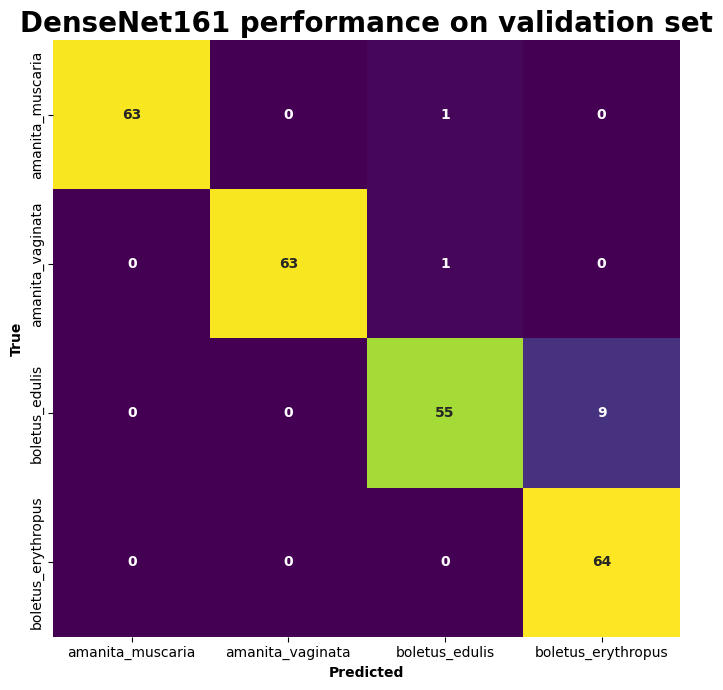

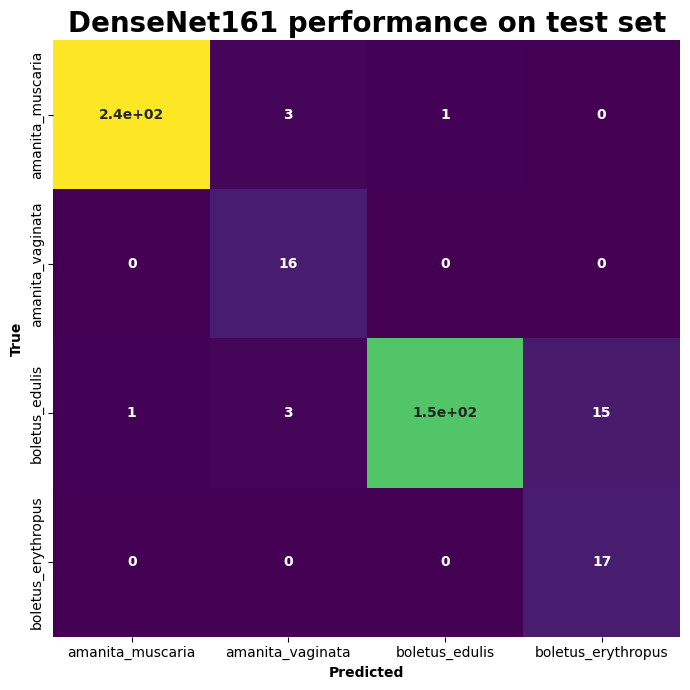

In [13]:
# Predicting on validation set
model_val_pred = model_ops.make_predictions(model = model,
                                            test_dataloader = val_loader,
                                            device = device)

# Confusion matrix
utils.plot_confusion_matrix(y_true = model_val_pred["true_labels"],
                            y_pred = model_val_pred["predictions"],
                            class_names = class_names,
                            norm = None,
                            title = f"DenseNet161 performance on validation set")

# Predicting on test set
model_test_pred = model_ops.make_predictions(model = model,
                                             test_dataloader = test_loader,
                                             device = device)

# Confusion matrix
utils.plot_confusion_matrix(y_true = model_test_pred["true_labels"],
                            y_pred = model_test_pred["predictions"],
                            class_names = class_names,
                            norm = None,
                            title = f"DenseNet161 performance on test set")

### Some stats

In [6]:
# Model size
print(f"DenseNet161 size: {densenet161_weights_path.stat().st_size / (1024*1024):.2f} MB")

DenseNet161 size: 102.21 MB


In [28]:
val_pred_list = model_ops.pred_and_track(model = model,
                                         path_list = val_paths_list,
                                         transform = transformer,
                                         class_names = class_names)
test_pred_list = model_ops.pred_and_track(model = model,
                                          path_list = test_paths_list,
                                          transform = transformer,
                                          class_names = class_names)

Predicting:   0%|          | 0/256 [00:00<?, ?it/s]

Predicting:   0%|          | 0/446 [00:00<?, ?it/s]

In [34]:
# Creating a dataframe with the list of dicts
val_df = pd.DataFrame(val_pred_list)
test_df = pd.DataFrame(test_pred_list)

print(f"Mean time for predictions on validation set {val_df.time_for_pred.mean():.4f} sec")
print(f"Mean time for predictions on test set {test_df.time_for_pred.mean():.4f} sec")

print(f"\nPredictions on validation set:\nCorret: {val_df.correct.value_counts()[0]}\nWrong: {val_df.correct.value_counts()[1]}")
print(f"\nPredictions on test set:\nCorret: {test_df.correct.value_counts()[0]}\nWrong: {test_df.correct.value_counts()[1]}")

Mean time for predictions on validation set 0.4268 sec
Mean time for predictions on test set 0.3934 sec

Predictions on validation set:
Corret: 245
Wrong: 11

Predictions on test set:
Corret: 423
Wrong: 23


The model has an acceptable performance so we can go ahead with deployment on [HuggingFace](https://huggingface.co/) using [Gradio](https://www.gradio.app/).

## Getting ready to upload the model

Despite the model was trained on a GPU the model won't run on a GPU in real life so we have to set put it on a cpu.

In [39]:
model.to("cpu")
next(iter(model.parameters())).device

device(type='cpu')

In [41]:
# Create a list for edibility
edibility_list = ["Toxic", "Not edible", "Great", "Toxic when raw"]

### Creating a function to make predictions

In [54]:
def predict(img):
  """
  Transforms and makes prediction on an image and return prediction and time.
  """

  start_time = timer()

  img = transformer(img).unsqueeze(0)

  model.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(model(img), dim=1)

  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  pred_info = edibility_list[np.argmax(pred_probs)]

  pred_time = round(timer() - start_time, 5)

  return pred_labels_and_probs, pred_info, pred_time